# Model Prediction of the Cause of Power outages across the United States

**Name(s)**: Tom Hocquet and Julia Ma

**Website Link**: https://tomok59.github.io/power_outage_model/

## Code

In [1]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import matplotlib.pyplot as plt
pd.options.plotting.backend = 'plotly'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, r2_score

### Framing the Problem

In [2]:
df = pd.read_excel('outage_copy.xlsx', header=5)
df = df.drop([0]).drop(columns='variables').set_index('OBS')
df['YEAR'] = df['YEAR'].astype(int)
df = df.reset_index()
def to_day(col):
    if str(col)[8:10] == '':
        return '00'
    return str(col)[8:10]
def to_hour(col):
    if str(col)[0:2] == 'na':
        return '25'
    return str(col)[0:2]
df['START.DAY'] = df['OUTAGE.START.DATE'].apply(to_day)
df['START.HOUR'] = df['OUTAGE.START.TIME'].apply(to_hour)
df['END.DAY'] = df['OUTAGE.RESTORATION.DATE'].apply(to_day)
df['END.HOUR'] = df['OUTAGE.RESTORATION.TIME'].apply(to_hour)
df = df.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME'])
df = df.drop(columns=['HURRICANE.NAMES', 'POSTAL.CODE', 'CAUSE.CATEGORY.DETAIL', 'OBS'])
df

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,...,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,START.DAY,START.HOUR,END.DAY,END.HOUR
0,2011,7.0,Minnesota,MRO,East North Central,-0.3,normal,severe weather,3060,NaN,...,18.2,2.14,0.6,91.592666,8.407334,5.478743,01,17,03,20
1,2014,5.0,Minnesota,MRO,East North Central,-0.1,normal,intentional attack,1,NaN,...,18.2,2.14,0.6,91.592666,8.407334,5.478743,11,18,11,18
2,2010,10.0,Minnesota,MRO,East North Central,-1.5,cold,severe weather,3000,NaN,...,18.2,2.14,0.6,91.592666,8.407334,5.478743,26,20,28,22
3,2012,6.0,Minnesota,MRO,East North Central,-0.1,normal,severe weather,2550,NaN,...,18.2,2.14,0.6,91.592666,8.407334,5.478743,19,04,20,23
4,2015,7.0,Minnesota,MRO,East North Central,1.2,warm,severe weather,1740,250,...,18.2,2.14,0.6,91.592666,8.407334,5.478743,18,02,19,07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2011,12.0,North Dakota,MRO,West North Central,-0.9,cold,public appeal,720,155,...,3.9,0.27,0.1,97.599649,2.401765,2.401765,06,08,06,20
1530,2006,NaN,North Dakota,MRO,West North Central,NaN,NaN,fuel supply emergency,NaN,1650,...,3.9,0.27,0.1,97.599649,2.401765,2.401765,00,25,00,25
1531,2009,8.0,South Dakota,RFC,West North Central,0.5,warm,islanding,59,84,...,4.7,0.3,0.15,98.307744,1.692256,1.692256,29,22,29,23
1532,2009,8.0,South Dakota,MRO,West North Central,0.5,warm,islanding,181,373,...,4.7,0.3,0.15,98.307744,1.692256,1.692256,29,11,29,14


In [3]:
df.isna().sum()

YEAR                    0
MONTH                   9
U.S._STATE              0
NERC.REGION             0
CLIMATE.REGION          6
ANOMALY.LEVEL           9
CLIMATE.CATEGORY        9
CAUSE.CATEGORY          0
OUTAGE.DURATION        58
DEMAND.LOSS.MW        705
CUSTOMERS.AFFECTED    443
RES.PRICE              22
COM.PRICE              22
IND.PRICE              22
TOTAL.PRICE            22
RES.SALES              22
COM.SALES              22
IND.SALES              22
TOTAL.SALES            22
RES.PERCEN             22
COM.PERCEN             22
IND.PERCEN             22
RES.CUSTOMERS           0
COM.CUSTOMERS           0
IND.CUSTOMERS           0
TOTAL.CUSTOMERS         0
RES.CUST.PCT            0
COM.CUST.PCT            0
IND.CUST.PCT            0
PC.REALGSP.STATE        0
PC.REALGSP.USA          0
PC.REALGSP.REL          0
PC.REALGSP.CHANGE       0
UTIL.REALGSP            0
TOTAL.REALGSP           0
UTIL.CONTRI             0
PI.UTIL.OFUSA           0
POPULATION              0
POPPCT_URBAN

In [4]:
na_cols = df.columns[df.isna().any()].tolist()
values_to_remove = ['CLIMATE.REGION',
 'ANOMALY.LEVEL',
 'CLIMATE.CATEGORY']
filtered_list = list(filter(lambda x: x not in values_to_remove, na_cols))
filtered_list
for colns in filtered_list:
    df[colns] = df[colns].fillna(-1)
df.isna().sum()

YEAR                  0
MONTH                 0
U.S._STATE            0
NERC.REGION           0
CLIMATE.REGION        6
ANOMALY.LEVEL         9
CLIMATE.CATEGORY      9
CAUSE.CATEGORY        0
OUTAGE.DURATION       0
DEMAND.LOSS.MW        0
CUSTOMERS.AFFECTED    0
RES.PRICE             0
COM.PRICE             0
IND.PRICE             0
TOTAL.PRICE           0
RES.SALES             0
COM.SALES             0
IND.SALES             0
TOTAL.SALES           0
RES.PERCEN            0
COM.PERCEN            0
IND.PERCEN            0
RES.CUSTOMERS         0
COM.CUSTOMERS         0
IND.CUSTOMERS         0
TOTAL.CUSTOMERS       0
RES.CUST.PCT          0
COM.CUST.PCT          0
IND.CUST.PCT          0
PC.REALGSP.STATE      0
PC.REALGSP.USA        0
PC.REALGSP.REL        0
PC.REALGSP.CHANGE     0
UTIL.REALGSP          0
TOTAL.REALGSP         0
UTIL.CONTRI           0
PI.UTIL.OFUSA         0
POPULATION            0
POPPCT_URBAN          0
POPPCT_UC             0
POPDEN_URBAN          0
POPDEN_UC       

In [5]:
df = df.dropna()
df.shape

(1520, 52)

### Baseline Model

In [6]:
## make initial split for test at the end

df_1 = df.copy()
df_X = df_1.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_1[['CAUSE.CATEGORY']]

X_train, X_test_final, y_train, y_test_final = (
    train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
)
df_1 = X_train
df_1['CAUSE.CATEGORY'] = y_train
df_1

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,...,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,START.DAY,START.HOUR,END.DAY,END.HOUR,CAUSE.CATEGORY
1450,2012,11.0,Massachusetts,NPCC,Northeast,0.1,normal,1,0,0.0,...,38.29,1.17,73.905628,26.094372,4.604889,15,5,15,5,intentional attack
27,2011,4.0,Tennessee,SERC,Central,-0.5,cold,660,300,63000.0,...,7.05,1.72,97.843109,2.156891,2.156891,4,13,5,0,severe weather
467,2016,5.0,Washington,WECC,Northwest,0.6,warm,-1,-1,-1.0,...,3.57,0.62,93.208786,6.791214,2.405397,8,9,0,25,islanding
1284,2014,4.0,California,WECC,West,-0.2,normal,1,-1,-1.0,...,5.28,0.59,95.164177,4.835823,1.730658,8,13,8,13,intentional attack
907,2012,1.0,Delaware,RFC,Northeast,-0.7,cold,0,0,0.0,...,20.88,6.21,78.304540,21.695460,3.656087,12,8,12,8,intentional attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,2008,9.0,Ohio,RFC,Central,-0.3,normal,11531,469,564728.0,...,10.82,2.05,91.154687,8.845313,1.057422,14,17,22,17,severe weather
910,2013,1.0,Iowa,MRO,East North Central,-0.4,normal,1637,-1,-1.0,...,1.71,0.66,99.260747,0.739253,0.739253,16,7,17,10,intentional attack
1101,2009,11.0,California,WECC,West,1.1,warm,945,630,-1.0,...,5.28,0.59,95.164177,4.835823,1.730658,18,6,18,22,equipment failure
235,2000,3.0,Texas,TRE,South,-1.1,cold,70,400,100000.0,...,3.35,0.58,97.258336,2.742036,2.090873,18,16,18,17,system operability disruption


In [7]:
# first guess of relevant columns : 'OUTAGE.DURATION', 'YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'AREAPCT_URBAN'
model_1_df = df_1[['OUTAGE.DURATION', 'YEAR', 'MONTH', 'U.S._STATE', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'AREAPCT_URBAN', 'CAUSE.CATEGORY']]
model_1_df

,OUTAGE.DURATION,YEAR,MONTH,U.S._STATE,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,AREAPCT_URBAN,CAUSE.CATEGORY
1450,1,2012,11.0,Massachusetts,13.05,4294884,3109560.0,38.29,intentional attack
27,660,2011,4.0,Tennessee,8.91,7278927,3174123.0,7.05,severe weather
467,-1,2016,5.0,Washington,7.48,6669170,3382664.0,3.57,islanding
1284,1,2014,4.0,California,11.74,19847009,15079226.0,5.28,intentional attack
907,0,2012,1.0,Delaware,10.78,990197,451908.0,20.88,intentional attack
...,...,...,...,...,...,...,...,...,...
718,11531,2008,9.0,Ohio,8.54,12821117,5525586.0,10.82,severe weather
910,1637,2013,1.0,Iowa,7.73,4132984,1572284.0,1.71,intentional attack
1101,945,2009,11.0,California,11.36,19159063,14789510.0,5.28,equipment failure
235,70,2000,3.0,Texas,5.91,21870637,9299829.0,3.35,system operability disruption


In [8]:
X_train, X_test, y_train, y_test = (
    train_test_split(model_1_df[['OUTAGE.DURATION', 'YEAR', 'MONTH', 'U.S._STATE', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'AREAPCT_URBAN']], model_1_df['CAUSE.CATEGORY'],test_size=0.25, random_state=1)
)

In [9]:
scaler = StandardScaler()
neigh = KNeighborsClassifier(n_neighbors=10)
preprocessor = ColumnTransformer(
        transformers=[
            ('STD_Sales', scaler, ['TOTAL.SALES']),
            ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'YEAR', 'MONTH']),
        ],
        remainder='passthrough'
    )
pipeline = Pipeline([
        ('prepocessor', preprocessor),
        ('knn', neigh)
    ])
pipeline.fit(X_train, y_train)

print('Train Error: ' + str(1-pipeline.score(X_train, y_train)))
print('Test Error: ' + str(1-pipeline.score(X_test, y_test)))

Train Error: 0.33684210526315794
Test Error: 0.39649122807017545


In [10]:
preds_knn = pipeline.predict(X_train)
f1_score(preds_knn, y_train, average = 'weighted')

0.7108217463207122

In [11]:
preds_knn = pipeline.predict(X_test)
f1_score(preds_knn, y_test, average = 'weighted')

0.6438866343750854

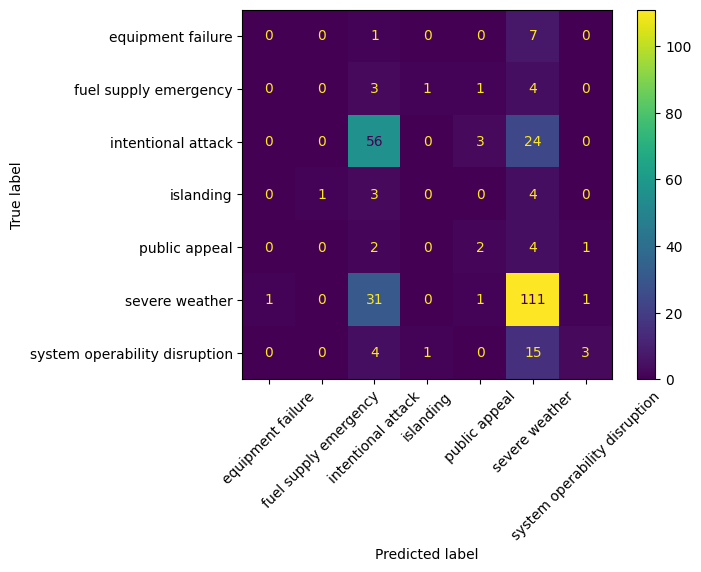

In [12]:
preds_knn_train = pipeline.predict(X_train)
f1_score(preds_knn_train, y_train, average = 'weighted')
preds_knn_test  = pipeline.predict(X_test)
f1_score(preds_knn_test, y_test, average = 'weighted')
metrics.confusion_matrix(y_test, preds_knn_test)
cm = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, xticks_rotation = 45)
plt.grid(False)

In [13]:
train_accuracy = metrics.accuracy_score(preds_knn_train, y_train)
train_accuracy

0.6631578947368421

In [14]:
test_accuracy = metrics.accuracy_score(preds_knn_test, y_test)
test_accuracy

0.6035087719298246

In [15]:
metrics.precision_score(y_test, preds_knn_test, average = 'weighted', zero_division = 1)

0.5546951402174075

In [16]:
metrics.recall_score(y_test, preds_knn_test, average = 'weighted')

0.6035087719298246

### Final Model

In [17]:
hyperparameters_knn = {
    'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10,15,20,25],
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__p': [1,2]
}
searcher = GridSearchCV(pipeline, hyperparameters_knn, cv=5)
searcher.fit(X_train, y_train)
searcher.best_params_

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/neighbo

{'knn__algorithm': 'auto',
 'knn__n_neighbors': 25,
 'knn__p': 1,
 'knn__weights': 'distance'}

In [18]:
best_params = {key[5:]: value for key, value in searcher.best_params_.items()}
neigh_v2 = KNeighborsClassifier(**best_params)
preprocessor_knn_v2 = ColumnTransformer(
        transformers=[
            ('STD_Sales', scaler, ['TOTAL.SALES']),
            ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'YEAR', 'MONTH']),
        ],
        remainder='passthrough'
    )
pipeline_knn_v2 = Pipeline([
        ('prepocessor', preprocessor_knn_v2),
        ('knn', neigh_v2)
    ])
pipeline_knn_v2.fit(X_train, y_train)
print('Train Error: ' + str(1-pipeline_knn_v2.score(X_train, y_train)))
print('Test Error: ' + str(1-pipeline_knn_v2.score(X_test, y_test)))


Train Error: 0.002339181286549752
Test Error: 0.4


Error went down 3% by finding best parameters

tree for each column with depth 5, sorted by f1score min error

In [19]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']

column_name = []
tr_err = []
ts_err = []
f1_Scores_TR = []
f1_Scores_TS = []
X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )

for col in numeric_columns:
    std_scaler = StandardScaler()
    tree = RandomForestClassifier(max_depth=5)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', [col])
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ])
    pipeline_tree.fit(X_train, y_train)
    column_name.append(col + ' NUM')
    tr_err.append(1-pipeline_tree.score(X_train, y_train))
    ts_err.append(1-pipeline_tree.score(X_test, y_test))
    preds_TR = pipeline_tree.predict(X_train)
    f1_Scores_TR.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
    preds_TS = pipeline_tree.predict(X_test)
    f1_Scores_TS.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

for col in categorical_columns:
    std_scaler = StandardScaler()
    tree = RandomForestClassifier(max_depth=5)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('One_Hot', OneHotEncoder(handle_unknown='ignore'), [col]),
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ])
    pipeline_tree.fit(X_train, y_train)
    column_name.append(col + ' CAT')
    tr_err.append(1-pipeline_tree.score(X_train, y_train))
    ts_err.append(1-pipeline_tree.score(X_test, y_test))
    preds_TR = pipeline_tree.predict(X_train)
    f1_Scores_TR.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
    preds_TS = pipeline_tree.predict(X_test)
    f1_Scores_TS.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

errors = pd.DataFrame()
errors['column'] = column_name
errors['train_err'] = tr_err
errors['test_err'] = ts_err
errors['F1_train_err'] = f1_Scores_TR
errors['F1_test_err'] = f1_Scores_TS
errors.sort_values(by='F1_test_err')

,column,train_err,test_err,F1_train_err,F1_test_err
5,CUSTOMERS.AFFECTED NUM,0.243275,0.252632,0.194144,0.206033
18,COM.CUSTOMERS NUM,0.370760,0.368421,0.298433,0.289211
37,POPDEN_RURAL NUM,0.397661,0.378947,0.309219,0.294345
32,POPULATION NUM,0.354386,0.371930,0.280477,0.298424
33,POPPCT_URBAN NUM,0.392982,0.382456,0.306518,0.300034
34,POPPCT_UC NUM,0.397661,0.378947,0.311057,0.300515
39,AREAPCT_UC NUM,0.404678,0.382456,0.316246,0.300676
20,TOTAL.CUSTOMERS NUM,0.357895,0.371930,0.278899,0.302576
36,POPDEN_UC NUM,0.409357,0.389474,0.320777,0.303476
35,POPDEN_URBAN NUM,0.401170,0.389474,0.310434,0.304196


We can see our best column is 'CUSTOMERS.AFFECTED'. Let's combine that column with other ones to see the scores we get!

In [20]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']

column_name = []
tr_err = []
ts_err = []
f1_Scores_TR = []
f1_Scores_TS = []
X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )
col1 = ['CUSTOMERS.AFFECTED']
for col in numeric_columns:
    col1 = ['CUSTOMERS.AFFECTED']
    col1.append(col)
    tree = RandomForestClassifier(max_depth=15)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', col1)
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ])
    column_name.append(str(col1) + ' NUM')
    temp_train = []
    temp_test =[]
    temp_f1_tr =[]
    temp_f1_ts = []
    for i in range(10):
        pipeline_tree.fit(X_train, y_train)
        
        temp_train.append(1-pipeline_tree.score(X_train, y_train))
        temp_test.append(1-pipeline_tree.score(X_test, y_test))

        preds_TR = pipeline_tree.predict(X_train)
        temp_f1_tr.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
        preds_TS = pipeline_tree.predict(X_test)
        temp_f1_ts.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

    tr_err.append(np.mean(temp_train))
    ts_err.append(np.mean(temp_test))
    f1_Scores_TR.append(np.mean(temp_f1_tr))
    f1_Scores_TS.append(np.mean(temp_f1_ts))

for col in categorical_columns:
    col1 = ['CUSTOMERS.AFFECTED']
    tree = RandomForestClassifier(max_depth=15)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', col1),
                ('One_Hot', OneHotEncoder(handle_unknown='ignore'), [col]),
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ]) 
    column_name.append(str(col1) + col + ' CAT')
    temp_train = []
    temp_test =[]
    temp_f1_tr =[]
    temp_f1_ts = []
    for i in range(10):
        pipeline_tree.fit(X_train, y_train)
        
        temp_train.append(1-pipeline_tree.score(X_train, y_train))
        temp_test.append(1-pipeline_tree.score(X_test, y_test))

        preds_TR = pipeline_tree.predict(X_train)
        temp_f1_tr.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
        preds_TS = pipeline_tree.predict(X_test)
        temp_f1_ts.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

    tr_err.append(np.mean(temp_train))
    ts_err.append(np.mean(temp_test))
    f1_Scores_TR.append(np.mean(temp_f1_tr))
    f1_Scores_TS.append(np.mean(temp_f1_ts))

errors = pd.DataFrame()
errors['column'] = column_name
errors['train_err'] = tr_err
errors['test_err'] = ts_err
errors['F1_train_err'] = f1_Scores_TR
errors['F1_test_err'] = f1_Scores_TS
errors.sort_values(by='F1_test_err')

,column,train_err,test_err,F1_train_err,F1_test_err
25,"['CUSTOMERS.AFFECTED', 'PC.REALGSP.USA'] NUM",0.131696,0.223509,0.118513,0.206656
0,"['CUSTOMERS.AFFECTED', 'YEAR'] NUM",0.131111,0.228070,0.118332,0.212437
47,['CUSTOMERS.AFFECTED']U.S._STATE CAT,0.190175,0.255088,0.163305,0.215147
13,"['CUSTOMERS.AFFECTED', 'TOTAL.SALES'] NUM",0.005497,0.226667,0.005493,0.215550
32,"['CUSTOMERS.AFFECTED', 'POPULATION'] NUM",0.053099,0.227719,0.053347,0.223188
7,"['CUSTOMERS.AFFECTED', 'COM.PRICE'] NUM",0.031813,0.240351,0.031554,0.224672
4,"['CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW'] NUM",0.114152,0.257895,0.103654,0.225340
10,"['CUSTOMERS.AFFECTED', 'RES.SALES'] NUM",0.004561,0.236842,0.004531,0.228258
6,"['CUSTOMERS.AFFECTED', 'RES.PRICE'] NUM",0.031462,0.241053,0.031232,0.232594
9,"['CUSTOMERS.AFFECTED', 'TOTAL.PRICE'] NUM",0.033099,0.243860,0.032862,0.234841


In [21]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']

column_name = []
tr_err = []
ts_err = []
f1_Scores_TR = []
f1_Scores_TS = []
X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )
col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP']
for col in numeric_columns:
    col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP']
    col1.append(col)
    tree = RandomForestClassifier(max_depth=15)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', col1)
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ])
    column_name.append(str(col1) + ' NUM')
    temp_train = []
    temp_test =[]
    temp_f1_tr =[]
    temp_f1_ts = []
    for i in range(10):
        pipeline_tree.fit(X_train, y_train)
        
        temp_train.append(1-pipeline_tree.score(X_train, y_train))
        temp_test.append(1-pipeline_tree.score(X_test, y_test))

        preds_TR = pipeline_tree.predict(X_train)
        temp_f1_tr.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
        preds_TS = pipeline_tree.predict(X_test)
        temp_f1_ts.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

    tr_err.append(np.mean(temp_train))
    ts_err.append(np.mean(temp_test))
    f1_Scores_TR.append(np.mean(temp_f1_tr))
    f1_Scores_TS.append(np.mean(temp_f1_ts))

for col in categorical_columns:
    col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP']
    log_transformer = FunctionTransformer(np.log, validate=True)
    tree = RandomForestClassifier(max_depth=15)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', col1),
                ('One_Hot', OneHotEncoder(handle_unknown='ignore'), [col]),
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ]) 
    column_name.append(str(col1) + col + ' CAT')
    temp_train = []
    temp_test =[]
    temp_f1_tr =[]
    temp_f1_ts = []
    for i in range(10):
        pipeline_tree.fit(X_train, y_train)
        
        temp_train.append(1-pipeline_tree.score(X_train, y_train))
        temp_test.append(1-pipeline_tree.score(X_test, y_test))

        preds_TR = pipeline_tree.predict(X_train)
        temp_f1_tr.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
        preds_TS = pipeline_tree.predict(X_test)
        temp_f1_ts.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

    tr_err.append(np.mean(temp_train))
    ts_err.append(np.mean(temp_test))
    f1_Scores_TR.append(np.mean(temp_f1_tr))
    f1_Scores_TS.append(np.mean(temp_f1_ts))

errors = pd.DataFrame()
errors['column'] = column_name
errors['train_err'] = tr_err
errors['test_err'] = ts_err
errors['F1_train_err'] = f1_Scores_TR
errors['F1_test_err'] = f1_Scores_TS
errors.sort_values(by='F1_test_err')

,column,train_err,test_err,F1_train_err,F1_test_err
7,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'COM.P...",0.003509,0.192982,0.003494,0.173538
2,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'ANOMA...",0.008889,0.188421,0.008834,0.178147
9,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL...",0.003626,0.192632,0.003626,0.178172
14,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'RES.P...",0.003626,0.192281,0.003630,0.178978
6,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'RES.P...",0.003626,0.195088,0.003609,0.187146
3,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'OUTAG...",0.001287,0.189123,0.001276,0.187891
8,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'IND.P...",0.003743,0.203158,0.003729,0.191535
11,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'COM.S...",0.003509,0.211579,0.003504,0.196905
1,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'MONTH...",0.003509,0.211228,0.003495,0.201351
50,"['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP']CLIMATE...",0.033918,0.209123,0.033621,0.202285


In [22]:
errors = errors.sort_values(by='F1_test_err')
errors.reset_index()
errors.iloc[0:10]['column'].to_list()

["['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'COM.PRICE'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'ANOMALY.LEVEL'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'RES.PERCEN'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'RES.PRICE'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'OUTAGE.DURATION'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'IND.PRICE'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'COM.SALES'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'MONTH'] NUM",
 "['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP']CLIMATE.CATEGORY CAT"]

In [23]:
df_X[['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'RES.PERCEN', 'U.S._STATE', 'MONTH']]

,CUSTOMERS.AFFECTED,TOTAL.REALGSP,TOTAL.PRICE,ANOMALY.LEVEL,OUTAGE.DURATION,RES.PERCEN,U.S._STATE,MONTH
1450,0.0,414029,13.05,0.1,1,35.491552,Massachusetts,11.0
27,63000.0,258910,8.91,-0.5,660,38.324811,Tennessee,4.0
467,-1.0,420809,7.48,0.6,-1,34.589237,Washington,5.0
1284,-1.0,2118858,11.74,-0.2,1,30.968057,California,4.0
907,0.0,57146,10.78,-0.7,0,43.151817,Delaware,1.0
...,...,...,...,...,...,...,...,...
718,564728.0,502597,8.54,-0.3,11531,30.376495,Ohio,9.0
910,-1.0,149313,7.73,-0.4,1637,37.138445,Iowa,1.0
1101,-1.0,1913674,11.36,1.1,945,31.955034,California,11.0
235,100000.0,944631,5.91,-1.1,70,29.754232,Texas,3.0


In [24]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']


X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )




col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'RES.PERCEN', 'MONTH']
tree = RandomForestClassifier(max_depth=15)
preprocessor_tree = ColumnTransformer(
        transformers=[
            ('column', 'passthrough', col1),
            ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CLIMATE.CATEGORY'])
        ],
        remainder='drop'
    )
pipeline_tree = Pipeline([
        ('prepocessor', preprocessor_tree),
        ('rf', tree)
    ])





pipeline_tree.fit(X_train, y_train)

preds_TR = pipeline_tree.predict(X_train)
preds_TS = pipeline_tree.predict(X_test)

print('Train Error: ' + str(1-pipeline_tree.score(X_train, y_train)))
print('Test Error: ' + str(1-pipeline_tree.score(X_test, y_test)))
print('F1 Train Error: ' + str(1-f1_score(preds_TR, y_train, average = 'weighted')))
print('F1 Test Error: ' + str(1-f1_score(preds_TS, y_test, average = 'weighted')))

Train Error: 0.0035087719298245723
Test Error: 0.17543859649122806
F1 Train Error: 0.003500598624920248
F1 Test Error: 0.1565609277972151


In [25]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']


X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )

temp_f1_tr = []
temp_f1_ts = []
temp_train = []
temp_test = []
depth = []
for i in range(25):
    col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'RES.PERCEN', 'MONTH']
    tree = RandomForestClassifier(max_depth=i+1)
    preprocessor_tree = ColumnTransformer(
            transformers=[
                ('column', 'passthrough', col1),
                ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CLIMATE.CATEGORY'])
            ],
            remainder='drop'
        )
    pipeline_tree = Pipeline([
            ('prepocessor', preprocessor_tree),
            ('rf', tree)
        ])

    pipeline_tree.fit(X_train, y_train)
    depth.append(i+1)
    temp_train.append(1-pipeline_tree.score(X_train, y_train))
    temp_test.append(1-pipeline_tree.score(X_test, y_test))

    preds_TR = pipeline_tree.predict(X_train)
    temp_f1_tr.append(1-f1_score(preds_TR, y_train, average = 'weighted'))
    preds_TS = pipeline_tree.predict(X_test)
    temp_f1_ts.append(1-f1_score(preds_TS, y_test, average = 'weighted'))

In [26]:
fig = pd.DataFrame({'train': temp_f1_tr, 'test': temp_f1_ts}, index=depth).plot().update_layout(
    xaxis_title='max_depth', yaxis_title='F1 error'
)
fig.show()

In [27]:
fig.write_html('max_depth.html', include_plotlyjs='cdn')

In [28]:
hyperparameters_tree ={
    #'rf__n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],
    'rf__criterion': ["gini", "entropy"],
    'rf__max_depth': [10, 15, 20, 25, 50],
    'rf__min_samples_split': [1.0, 2, 4, 8, 10],
    #'rf__min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'rf__max_features': ["auto", "log2", None]
}
searcher_tree = GridSearchCV(pipeline_tree, hyperparameters_tree, cv=5)
searcher_tree.fit(X_train, y_train)
searcher_tree.best_params_

KeyboardInterrupt: 

In [59]:
df_2 = df_1.copy()
df_X = df_2.drop(columns='CAUSE.CATEGORY')
numeric_columns = df_X.columns[df_X.apply(pd.to_numeric, errors='coerce').notna().all()]
df_X[numeric_columns] = df_X[numeric_columns].apply(pd.to_numeric, errors='coerce')
numeric_columns = df_X.select_dtypes(include=['number']).columns
categorical_columns = df_X.select_dtypes(include=['object']).columns
df_Y = df_2['CAUSE.CATEGORY']


X_train, X_test, y_train, y_test = (
        train_test_split(df_X, df_Y,test_size=0.25, random_state=1)
    )


col2 = ['OUTAGE.DURATION', 'TOTAL.PRICE']
std_scaler = StandardScaler()
tree = RandomForestClassifier(criterion='entropy', max_depth=15)
preprocessor_tree = ColumnTransformer(
        transformers=[
            ('column', 'passthrough', col1),
            ('std', std_scaler, col2),
            ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CLIMATE.CATEGORY'])
        ],
        remainder='drop'
    )
pipeline_tree = Pipeline([
        ('prepocessor', preprocessor_tree),
        ('rf', tree)
    ])

pipeline_tree.fit(X_train, y_train)

preds_TR = pipeline_tree.predict(X_train)
preds_TS = pipeline_tree.predict(X_test)

print('Train Error: ' + str(1-pipeline_tree.score(X_train, y_train)))
print('Test Error: ' + str(1-pipeline_tree.score(X_test, y_test)))
print('F1 Train Error: ' + str(1-f1_score(preds_TR, y_train, average = 'weighted')))
print('F1 Test Error: ' + str(1-f1_score(preds_TS, y_test, average = 'weighted')))

Train Error: 0.0
Test Error: 0.18596491228070178
F1 Train Error: 0.0
F1 Test Error: 0.16835315110458415


In [60]:
final_preds = pipeline_tree.predict(X_test_final)
print('F1 Test Error: ' + str(1-f1_score(final_preds, y_test_final, average = 'weighted')))

F1 Test Error: 0.1684792040342623


In [61]:
col1 = ['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'ANOMALY.LEVEL' , 'RES.PERCEN', 'MONTH']
col2 = ['OUTAGE.DURATION', 'TOTAL.PRICE']
std_scaler = StandardScaler()
tree = RandomForestClassifier(criterion='entropy', max_depth=15)
preprocessor_tree = ColumnTransformer(
        transformers=[
            ('column', 'passthrough', col1),
            ('std', std_scaler, col2),
            ('One_Hot', OneHotEncoder(handle_unknown='ignore'), ['U.S._STATE', 'CLIMATE.CATEGORY'])
        ],
        remainder='drop'
    )
final_pipe = Pipeline([
        ('prepocessor', preprocessor_tree),
        ('rf', tree)
    ])

final_pipe.fit(df, df['CAUSE.CATEGORY'])

Pipeline(steps=[('prepocessor',
                 ColumnTransformer(transformers=[('column', 'passthrough',
                                                  ['CUSTOMERS.AFFECTED',
                                                   'TOTAL.REALGSP',
                                                   'ANOMALY.LEVEL',
                                                   'RES.PERCEN', 'MONTH']),
                                                 ('std', StandardScaler(),
                                                  ['OUTAGE.DURATION',
                                                   'TOTAL.PRICE']),
                                                 ('One_Hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['U.S._STATE',
                                                   'CLIMATE.CATEGORY'])])),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=15))])

### Fairness Analysis

In [62]:
data = df.copy()
data = data[['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'RES.PERCEN', 'MONTH', 'U.S._STATE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']]
binarizer = Binarizer(threshold=10000)
data['Aff.Bin'] = binarizer.transform(data[['CUSTOMERS.AFFECTED']])
data0 = data[data['Aff.Bin']==0]
data1 = data[data['Aff.Bin']==1]
data0


/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names



,CUSTOMERS.AFFECTED,TOTAL.REALGSP,TOTAL.PRICE,ANOMALY.LEVEL,OUTAGE.DURATION,RES.PERCEN,MONTH,U.S._STATE,CLIMATE.CATEGORY,CAUSE.CATEGORY,Aff.Bin
1,-1.0,291955,9.28,-0.1,1,30.032487,5.0,Minnesota,normal,intentional attack,0.0
8,5941.0,292023,9.03,0.6,155,32.936916,3.0,Minnesota,warm,intentional attack,0.0
12,0.0,274182,9.28,-0.3,0,35.549073,7.0,Minnesota,normal,intentional attack,0.0
13,0.0,274182,8.70,-0.4,1322,29.805110,5.0,Minnesota,normal,intentional attack,0.0
15,-1.0,282752,9.59,1,19,41.177865,6.0,Tennessee,warm,system operability disruption,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1526,0.0,60911,8.05,1.6,0,40.930861,3.0,Idaho,warm,intentional attack,0.0
1527,0.0,60911,8.05,1.6,-1,40.930861,3.0,Idaho,warm,intentional attack,0.0
1528,-1.0,60911,-1.00,-0.3,220,-1.000000,7.0,Idaho,normal,system operability disruption,0.0
1531,-1.0,36504,7.67,0.5,59,36.564432,8.0,South Dakota,warm,islanding,0.0


In [67]:
pred0 = final_pipe.predict(data0.drop('CAUSE.CATEGORY', axis=1))
pred1 = final_pipe.predict(data1.drop('CAUSE.CATEGORY', axis=1))
f1_0 = f1_score(pred0, data0['CAUSE.CATEGORY'], average = 'weighted')
f1_1 = f1_score(pred1, data1['CAUSE.CATEGORY'], average = 'weighted')

obs_diff = f1_1-f1_0

print("F1 of Group 1:", f1_0)
print("F1 of Group 2:", f1_1)
print("Difference in F1 score", f1_1-f1_0)

F1 of Group 1: 0.9972445155723108
F1 of Group 2: 0.9937437853955152
Difference in F1 score -0.00350073017679553


In [64]:
f1_diffs = []
for i in range(1000):
    data = df.copy()
    data = data[['CUSTOMERS.AFFECTED', 'TOTAL.REALGSP', 'TOTAL.PRICE', 'ANOMALY.LEVEL', 'OUTAGE.DURATION', 'RES.PERCEN', 'MONTH', 'U.S._STATE', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY']]
    binarizer = Binarizer(threshold=10000)
    data['Aff.Bin'] = binarizer.transform(data[['CUSTOMERS.AFFECTED']])
    data['Aff.Bin'] = np.random.permutation(data['Aff.Bin'])

    data0 = data[data['Aff.Bin']==0]
    data1 = data[data['Aff.Bin']==1]

    pred0 = final_pipe.predict(data0.drop('CAUSE.CATEGORY', axis=1))
    pred1 = final_pipe.predict(data1.drop('CAUSE.CATEGORY', axis=1))
    f1_0 = f1_score(pred0, data0['CAUSE.CATEGORY'], average = 'weighted')
    f1_1 = f1_score(pred1, data1['CAUSE.CATEGORY'], average = 'weighted')
    f1_diffs.append(f1_1-f1_0)

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Binarizer was fitted without feature names

/Users/dem

In [69]:
sum(f1_diffs > obs_diff)/len(f1_diffs)

0.803

In [68]:
fig = px.histogram(pd.DataFrame(f1_diffs), histnorm='probability', 
                title='Difference of F1 Score')
fig.add_vline(x=obs_diff, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed Diff = {round(obs_diff, 3)}</span>',
                x=2.3 * obs_diff, showarrow=False, y=0.16)
fig.update_layout(xaxis_range=[-0.02, 0.02])
fig.show()

# p val
p_val = np.mean(np.array(f1_diffs) >= obs_diff)
p_val


0.804